# Fedbiomed to train a federated SGD regressor model

## Data 


This tutorial shows how to deploy in Fed-BioMed to solve a federated regression problem with scikit-learn.

In this tutorial we are using the wrapper of Fed-BioMed for the SGD regressor (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html).
The goal of the notebook is to train a model on a realistic dataset of (synthetic) medical information mimicking the ADNI dataset (http://adni.loni.usc.edu/). 

## Creating nodes

To proceed with the tutorial, we create 3 clients with corresponding dataframes of clinical information in .csv format. Each client has 300 data points composed by several features corresponding to clinical and medical imaging informations. **The data is entirely synthetic and randomly sampled to mimick the variability of the real ADNI dataset**. The training partitions are availables at the following link:

https://drive.google.com/file/d/1R39Ir60oQi8ZnmHoPz5CoGCrVIglcO9l/view?usp=sharing

The federated task we aim at solve is to predict a clinical variable (the mini-mental state examinatio, MMSE) from a combination of demographic and imaging features. The regressors variables are the following features:

['SEX', 'AGE', 'PTEDUCAT', 'WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']

and the target variable is:

['MMSE.bl']
    

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 1 (csv) to add the .csv partition of client 1, by just picking the .csv of client 1. We use `adni` as tag to save the selected dataset. We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.

## Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook with `./scripts/fedbiomed_run researcher`. 

We can first query the network for the adni dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `adni`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-01-10 15:03:20,966 fedbiomed INFO - Component environment:
2022-01-10 15:03:20,967 fedbiomed INFO - - type = ComponentType.RESEARCHER
2022-01-10 15:03:21,298 fedbiomed INFO - Messaging researcher_a7319768-5c08-43f6-a819-9a487cb1cc02 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x103a311c0>
2022-01-10 15:03:21,318 fedbiomed INFO - Listing available datasets in all nodes... 
2022-01-10 15:03:21,326 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'command': 'list'}
2022-01-10 15:03:21,327 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'command': 'list'}
2022-01-10 15:03:21,328 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / DEBUG - Message received: {'researcher_id': 'res

{'node_c27b3141-213a-4221-9dcf-7e885a30738b': [{'name': 'adni',
   'data_type': 'csv',
   'tags': ['adni'],
   'description': 'bla',
   'shape': [300, 20]}],
 'node_ff1ad308-d26a-4c73-8ffc-87df03618014': [{'name': 'adni',
   'data_type': 'csv',
   'tags': ['adni'],
   'description': 'bla',
   'shape': [300, 20]}],
 'node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf': [{'name': 'adni',
   'data_type': 'csv',
   'tags': ['adni'],
   'description': 'bla',
   'shape': [300, 20]}]}

In [3]:
import numpy as np
from fedbiomed.researcher.environ import environ
import tempfile
tmp_dir_model = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+'/')
model_file = tmp_dir_model.name + '/fedbiosklearn.py'

## Create an experiment to train a model on the data found

The code for network and data loader of the sklearn SGDRegressor can now be deployed in Fed-BioMed.
We first import the necessary module `SGDSkLearnModel` from `fedbiomed`:

**__init__** : we add here the needed sklearn libraries
       
**training_data** : you must return here the (X,y) that must be of the same type of 
your method partial_fit parameters. 

We note that this model performs a common standardization across federated datasets by **centering with respect to the same parameters**.

In [4]:
%%writefile "$model_file"

from fedbiomed.common.fedbiosklearn import SGDSkLearnModel
from sklearn.linear_model import SGDRegressor


class SGDRegressorTrainingPlan(SGDSkLearnModel):
    def __init__(self, kwargs):
        super(SGDRegressorTrainingPlan, self).__init__(kwargs)
        self.add_dependency(["from sklearn.linear_model import SGDRegressor"])
    
    def training_data(self):
        NUMBER_COLS = 5
        dataset = pd.read_csv(self.dataset_path,delimiter=',')
        regressors_col = ['SEX', 'AGE', 'PTEDUCAT', 'WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
        target_col = ['MMSE.bl']
        
        scaling_mean = np.array([0.8, 72.3, 16.2, 0.7, 0.0, 0.0, 0.0, 0.0])
        scaling_sd = np.array([3.5e-01, 7.3e+00, 2.7e+00, 5.0e-02, 1.1e-02, 1.0e-03, 2.0e-03, 1.0e-03])
        
        X = (dataset[regressors_col].values-scaling_mean)/scaling_sd
        y = dataset[target_col]
        return (X,y.values.ravel())
    

Writing /Users/mlorenzi/works/temp/fedbiomed/var/tmp/tmpgu33_tb6/fedbiosklearn.py


**model_args** is a dictionary containing your model arguments, in case of SGDRegressor this will be max_iter and tol. n_features is provided to correctly initialize the SGDRegressor coef_ array.

**training_args** is a dictionary with parameters related to Federated Learning. 

In [5]:
model_args = { 'max_iter':1000, 'tol': 1e-3 , 'model': 'SGDRegressor' , 'n_features': 8}

training_args = {
    'epochs': 5, 
}

The experiment can be now defined, by providing the `adni` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 10 optimization rounds.

In [6]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['adni']
rounds = 10

# select nodes participing to this experiment
exp = Experiment(tags=tags,
                 #nodes=None,
                 model_path=model_file,
                 model_args=model_args,
                 model_class='SGDRegressorTrainingPlan',
                 training_args=training_args,
                 rounds=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

2022-01-10 15:03:33,031 fedbiomed INFO - Searching dataset with data tags: ['adni'] for all nodes
2022-01-10 15:03:33,038 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'tags': ['adni'], 'command': 'search'}
2022-01-10 15:03:33,039 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'tags': ['adni'], 'command': 'search'}
2022-01-10 15:03:33,043 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'tags': ['adni'], 'command': 'search'}
2022-01-10 15:03:43,044 fedbiomed INFO - Node selected for training -> node_c27b3141-213a-4221-9dcf-7e885a30738b
2022-01-10 15:03:43,045 fedbiomed INFO - Node selected for training -> node_0f5cb1d3-621f-45b9-9f45-4a

In [7]:
# start federated training
exp.run()

2022-01-10 15:03:43,224 fedbiomed INFO - Sampled nodes in round 0 ['node_c27b3141-213a-4221-9dcf-7e885a30738b', 'node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf', 'node_ff1ad308-d26a-4c73-8ffc-87df03618014']
2022-01-10 15:03:43,225 fedbiomed INFO - Send message to node node_c27b3141-213a-4221-9dcf-7e885a30738b - {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'training_args': {'epochs': 5}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_init_78cde51a-5391-48f1-ad8d-40df11a719f7.pt', 'model_class': 'SGDRegressorTrainingPlan', 'training_data': {'node_c27b3141-213a-4221-9dcf-7e885a30738b': ['dataset_706fc178-989a-4251-ab42-5850637cd0a6']}}
2022-01-10 15:03:43,2

2022-01-10 15:03:43,313 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x142b78c10>, 'epochs': 5}
2022-01-10 15:03:43,316 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / DEBUG - Dataset_path/Users/mlorenzi/works/temp/flhd_copy/heterogeneous_data/adni_client3.csv
2022-01-10 15:03:43,318 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / INFO - Train Epoch: 0 [Batch All Samples]	Loss: 4.349698
2022-01-10 15:03:43,321 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - Train Epoch: 0 [Batch All Samples]	Loss: 4.885737
2022-01-10 15:03:43,323 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - Train Epoch: 1 [Batch All Samples]	Loss: 3.287136
2022-01-10 15:03:43,325 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - Train Epoch: 2 [Batch All Samples]	Loss: 2.989265
2022-0

2022-01-10 15:03:53,373 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'training_args': {'epochs': 5}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_eda1790e-6638-4359-b842-150e88cbb2f9.pt', 'model_class': 'SGDRegressorTrainingPlan', 'training_data': {'node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf': ['dataset_253f8b93-4b7b-43af-bee7-59cff68e9cc6']}}
2022-01-10 15:03:53,376 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-35

2022-01-10 15:04:03,485 fedbiomed INFO - Send message to node node_c27b3141-213a-4221-9dcf-7e885a30738b - {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'training_args': {'epochs': 5}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_df4e434e-07fb-439a-995b-d54f2a85fcb2.pt', 'model_class': 'SGDRegressorTrainingPlan', 'training_data': {'node_c27b3141-213a-4221-9dcf-7e885a30738b': ['dataset_706fc178-989a-4251-ab42-5850637cd0a6']}}
2022-01-10 15:04:03,486 fedbiomed DEBUG - researcher_a7319768-5c08-43f6-a819-9a487cb1cc02
2022-01-10 15:04:03,487 fedbiomed INFO - Send message to node node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf - {'researcher_id': 'researcher_a7

2022-01-10 15:04:03,558 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / DEBUG - Dataset_path/Users/mlorenzi/works/temp/flhd_copy/heterogeneous_data/adni_client1.csv
2022-01-10 15:04:03,562 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - Train Epoch: 0 [Batch All Samples]	Loss: 2.924001
2022-01-10 15:04:03,565 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / INFO - Train Epoch: 0 [Batch All Samples]	Loss: 2.523479
2022-01-10 15:04:03,567 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - Train Epoch: 1 [Batch All Samples]	Loss: 2.889079
2022-01-10 15:04:03,569 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - Train Epoch: 2 [Batch All Samples]	Loss: 2.856118
2022-01-10 15:04:03,570 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / INFO - Train Epoch: 1 [Batch All Samples]	Loss: 2.518026
2022-01-10 15:04:03,572 fedbiomed INFO - log from: n

2022-01-10 15:04:13,626 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_e01feec1-a322-42c8-802b-e9823c46ccca.pt', 'training_args': {'epochs': 5}, 'training_data': {'node_c27b3141-213a-4221-9dcf-7e885a30738b': ['dataset_706fc178-989a-4251-ab42-5850637cd0a6']}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'model_class': 'SGDRegressorTrainingPlan', 'command': 'train'}
2022-01-10 15:04:13,628 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3

2022-01-10 15:04:23,743 fedbiomed INFO - Send message to node node_c27b3141-213a-4221-9dcf-7e885a30738b - {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'training_args': {'epochs': 5}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_3b3a8996-cf38-448e-b082-38f5dc84ef98.pt', 'model_class': 'SGDRegressorTrainingPlan', 'training_data': {'node_c27b3141-213a-4221-9dcf-7e885a30738b': ['dataset_706fc178-989a-4251-ab42-5850637cd0a6']}}
2022-01-10 15:04:23,744 fedbiomed DEBUG - researcher_a7319768-5c08-43f6-a819-9a487cb1cc02
2022-01-10 15:04:23,745 fedbiomed INFO - Send message to node node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf - {'researcher_id': 'researcher_a7

2022-01-10 15:04:23,823 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / DEBUG - Dataset_path/Users/mlorenzi/works/temp/flhd_copy/heterogeneous_data/adni_client3.csv
2022-01-10 15:04:23,825 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / INFO - Train Epoch: 0 [Batch All Samples]	Loss: 2.558005
2022-01-10 15:04:23,832 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / INFO - Train Epoch: 1 [Batch All Samples]	Loss: 2.524178
2022-01-10 15:04:23,837 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / INFO - Train Epoch: 2 [Batch All Samples]	Loss: 2.504676
2022-01-10 15:04:23,839 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / INFO - Train Epoch: 3 [Batch All Samples]	Loss: 2.479930
2022-01-10 15:04:23,841 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / INFO - Train Epoch: 4 [Batch All Samples]	Loss: 2.481412
2022-01-10 15:04:23,843 fedbiomed INFO - log from: n

2022-01-10 15:04:33,887 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_3894b198-24cc-457a-8bd2-edaeef4dca43.pt', 'training_args': {'epochs': 5}, 'training_data': {'node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf': ['dataset_253f8b93-4b7b-43af-bee7-59cff68e9cc6']}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'model_class': 'SGDRegressorTrainingPlan', 'command': 'train'}
2022-01-10 15:04:33,894 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3

2022-01-10 15:04:43,989 fedbiomed INFO - Send message to node node_c27b3141-213a-4221-9dcf-7e885a30738b - {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'training_args': {'epochs': 5}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_d1988b6f-92b6-4e3d-84df-fd46c770ebb8.pt', 'model_class': 'SGDRegressorTrainingPlan', 'training_data': {'node_c27b3141-213a-4221-9dcf-7e885a30738b': ['dataset_706fc178-989a-4251-ab42-5850637cd0a6']}}
2022-01-10 15:04:43,989 fedbiomed DEBUG - researcher_a7319768-5c08-43f6-a819-9a487cb1cc02
2022-01-10 15:04:43,990 fedbiomed INFO - Send message to node node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf - {'researcher_id': 'researcher_a7

2022-01-10 15:04:44,058 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / DEBUG - Dataset_path/Users/mlorenzi/works/temp/flhd_copy/heterogeneous_data/adni_client1.csv
2022-01-10 15:04:44,061 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - Train Epoch: 0 [Batch All Samples]	Loss: 2.713205
2022-01-10 15:04:44,065 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / INFO - Train Epoch: 0 [Batch All Samples]	Loss: 2.420411
2022-01-10 15:04:44,070 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / INFO - Train Epoch: 0 [Batch All Samples]	Loss: 2.474722
2022-01-10 15:04:44,072 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / INFO - Train Epoch: 1 [Batch All Samples]	Loss: 2.452183
2022-01-10 15:04:44,074 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / INFO - Train Epoch: 1 [Batch All Samples]	Loss: 2.482951
2022-01-10 15:04:44,076 fedbiomed INFO - log from: n

2022-01-10 15:04:54,137 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'training_args': {'epochs': 5}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_3cd49432-2317-48e3-b45b-65d6294dccd3.pt', 'model_class': 'SGDRegressorTrainingPlan', 'training_data': {'node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf': ['dataset_253f8b93-4b7b-43af-bee7-59cff68e9cc6']}}
2022-01-10 15:04:54,144 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-359

2022-01-10 15:05:04,264 fedbiomed INFO - Send message to node node_c27b3141-213a-4221-9dcf-7e885a30738b - {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'training_args': {'epochs': 5}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_57b1a8a2-4e8d-47fd-8dfd-3b09930bc326.pt', 'model_class': 'SGDRegressorTrainingPlan', 'training_data': {'node_c27b3141-213a-4221-9dcf-7e885a30738b': ['dataset_706fc178-989a-4251-ab42-5850637cd0a6']}}
2022-01-10 15:05:04,266 fedbiomed DEBUG - researcher_a7319768-5c08-43f6-a819-9a487cb1cc02
2022-01-10 15:05:04,268 fedbiomed INFO - Send message to node node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf - {'researcher_id': 'researcher_a7

2022-01-10 15:05:04,346 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / INFO - Train Epoch: 4 [Batch All Samples]	Loss: 2.418449
2022-01-10 15:05:04,348 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x142b78c10>, 'epochs': 5}
2022-01-10 15:05:04,350 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / DEBUG - Dataset_path/Users/mlorenzi/works/temp/flhd_copy/heterogeneous_data/adni_client3.csv
2022-01-10 15:05:04,359 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / INFO - {'monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1386eaaf0>, 'epochs': 5}
2022-01-10 15:05:04,360 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9f45-4a38758e5ebf / DEBUG - Dataset_path/Users/mlorenzi/works/temp/flhd_copy/heterogeneous_data/adni_client2.csv
2022-01-10 15:05:04,362 fedbiomed INFO - log from: node_0f5cb1d3-621f-45b9-9

2022-01-10 15:05:14,457 fedbiomed INFO - log from: node_ff1ad308-d26a-4c73-8ffc-87df03618014 / DEBUG - Message received: {'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-3590-49f2-a705-4c96d11ca738', 'training_args': {'epochs': 5}, 'model_args': {'max_iter': 1000, 'tol': 0.001, 'model': 'SGDRegressor', 'n_features': 8, 'verbose': 1}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/01/10/my_model_234eccb6-6e64-463d-bbf5-a21bc7893d1d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/01/10/aggregated_params_f271f382-db9d-4414-87de-4f60a011c7e1.pt', 'model_class': 'SGDRegressorTrainingPlan', 'training_data': {'node_ff1ad308-d26a-4c73-8ffc-87df03618014': ['dataset_6449edb0-8037-4071-beb2-9da26a529c98']}}
2022-01-10 15:05:14,459 fedbiomed INFO - log from: node_c27b3141-213a-4221-9dcf-7e885a30738b / DEBUG - [TASKS QUEUE] Item:{'researcher_id': 'researcher_a7319768-5c08-43f6-a819-9a487cb1cc02', 'job_id': '3419b15e-35

##  Testing

Once the federated model is obtained, it is possible to test it locally on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1zNUGp6TMn6WSKYVC8FQiQ9lJAUdasxk1/

In [8]:
!pip install matplotlib
!pip install gdown

Download the testing dataset on the local temporary folder.

In [9]:
import os
import gdown
import zipfile

resource = "https://drive.google.com/uc?id=19kxuI146WA2fhcOU2_AvF8dy-ppJkzW7"
base_dir = tmp_dir_model.name 

test_file = os.path.join(base_dir, "test_data.zip")
gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)


Downloading...
From: https://drive.google.com/uc?id=19kxuI146WA2fhcOU2_AvF8dy-ppJkzW7
To: /Users/mlorenzi/works/temp/fedbiomed/var/tmp/tmpgu33_tb6/test_data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12.4k/12.4k [00:00<00:00, 7.47MB/s]


In [10]:
import pandas as pd
n_features = 8

test_data = pd.read_csv(os.path.join(base_dir,'adni_validation.csv'))

In [11]:
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt

In [12]:
%matplotlib inline

Here we extract the relevant regressors and target from the testing data 

In [13]:
regressors_col = ['SEX', 'AGE', 'PTEDUCAT', 'WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
target_col = ['MMSE.bl']
X_test = test_data[regressors_col].values
y_test = test_data[target_col].values

To inspect the model evolution across FL rounds, we export `exp.aggregated_params` containing models parameters collected at the end of each round. The MSE should be decreasing at each iteration with the federated parameters. 

Text(0, 0.5, 'testing loss')

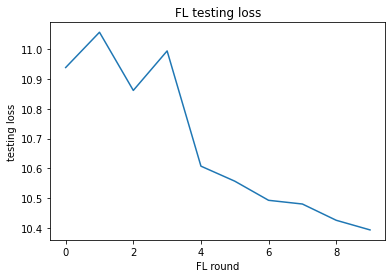

In [14]:
scaling_mean = np.array([0.8, 72.3, 16.2, 0.7, 0.0, 0.0, 0.0, 0.0])
scaling_sd = np.array([3.5e-01, 7.3e+00, 2.7e+00, 5.0e-02, 1.1e-02, 1.0e-03, 2.0e-03, 1.0e-03])

testing_error = []

for i in range(rounds):
    fed_model = SGDRegressor(max_iter=1000, tol=1e-3)
    fed_model.coef_ = exp.aggregated_params[i]['params']['coef_'].copy()
    fed_model.intercept_ = exp.aggregated_params[i]['params']['intercept_'].copy()  
    mse = np.mean((fed_model.predict((X_test-scaling_mean)/scaling_sd) - y_test)**2)
    testing_error.append(mse)

plt.plot(testing_error)
plt.title('FL testing loss')
plt.xlabel('FL round')
plt.ylabel('testing loss')

We finally inspect the predictions of the final federated model on the testing data.

Text(0.5, 1.0, 'Federated model testing prediction')

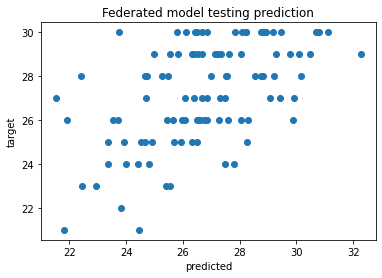

In [15]:
plt.scatter(fed_model.predict((X_test-scaling_mean)/scaling_sd), y_test)
plt.xlabel('predicted')
plt.ylabel('target')
plt.title('Federated model testing prediction')